### The aim is to check how the cluster power geographical distributions changes under global warming

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib
from matplotlib.ticker import MaxNLocator,FormatStrFormatter
import pickle
from glob import glob
import sys  
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
from dateutil.relativedelta import relativedelta
import itertools
import pickle
from cartopy.util import add_cyclic_point


from scipy.ndimage import label,find_objects
import scipy.ndimage as ndimage
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import NearestNDInterpolator,RegularGridInterpolator


import datetime as dt

import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import pandas as pd
from scipy.stats import norm
import os 
# import seaborn as sns
import cftime

%matplotlib inline

### Get names of all models you want to plot ###

In [3]:
!ls *.out

clusters_output_BCC-CSM2-MR_200201_201412.out
clusters_output_CNRM-CM6-1_200201_201412.out
clusters_output_KACE-1-0-G_199001_199912.out
clusters_output_SSP585_BCC-CSM2-MR_209101_210012.out
clusters_output_SSP585_CNRM-CM6-1_209101_210012.out
clusters_output_SSP585_@KACE-1-0-G_209101_210012.out
clusters_output_TRMM3B42_200201_201412.out


### Enter a single model name into the list below ###

In [4]:
### KACE SSP only runs from 2095-2100, so we must be careful to only use temperature values from that range for scaling ###

In [37]:
obs_name=['TRMM3B42_200201_201412']
model_names_HIST=['BCC-CSM2-MR_200201_201412']
model_names_SSP=['BCC-CSM2-MR_209101_210012']
model_names_SSP=['SSP585_'+i for i in model_names_SSP] ## adding the SSP585 prefix to all models 

## !!!! Don't forget to change model name here !!!!
model_name={}
model_name['HIST']='CNRM-CM6-1'
model_name['SSP']='CNRM-CM6-1'

### read surface temperature info ###

In [219]:
!ls /neelin2020/CMIP6-SSP585/@KACE-1-0-G/tas

tas_3hr_KACE-1-0-G_ssp585_r1i1p1f1_gr_209501010130-210012302230.nc
tas_day_KACE-1-0-G_ssp585_r1i1p1f1_gr_20150101-21001230.nc


### Reading surface temperature data

In [17]:
keys=['HIST','SSP']

direc={key: None for key in keys}

direc['HIST']='/neelin2020/CMIP6-HISTORICAL/'
direc['SSP']='/neelin2020/CMIP6-SSP585/'

ta_dir={'HIST':'tas','SSP':'tas'}  # change the directory name between ta and tas as required 
ta_ext={'HIST':'tas_3hr','SSP':'tas_3hr'}

### Set temperature variable name ###
TA_VAR={'HIST':'tas','SSP':'ta'}

model_dir={key: [] for key in keys}
model_list={key: [] for key in keys}

model_index={key: None for key in keys}

for key in ['HIST','SSP']:
    print(key)
    diri=direc[key]
    list_temp=(glob(diri+'*'))

    for name in list_temp:
        temp_name=name.split('/')[-1]
        model_list[key].append(temp_name)
        model_dir[key].append(diri+temp_name+'/'+ta_dir[key]+'/'+ta_ext[key]+'*')


#     model_list[key]=model_list[key][1:] ### neglect the first name, since it is not really a model
#     model_dir[key]=model_dir[key][1:] ### neglect the first name, since it is not really a model
    print(model_list[key])
    model_index[key]=model_list[key].index(model_name[key]) ## find index of any model you want    

HIST
[]


ValueError: 'BCC-CSM2-MR' is not in list

In [19]:
strt_date={key:None for key in keys}
end_date={key:None for key in keys}

## Specify start and end dates to extract from for SSP
strt_date['SSP']=dt.datetime(2091,1,1)
end_date['SSP']=dt.datetime(2100,12,31)

## and HIST
strt_date['HIST']=dt.datetime(2005,1,1)
end_date['HIST']=dt.datetime(2014,12,31)

if model_name['HIST'] in ['KACE-1-0-G']:

    
    strt_date['HIST']=cftime.Datetime360Day(1990, 1, 1, 0)
    end_date['HIST']=cftime.Datetime360Day(1999,12,30)
    
    strt_date['SSP']=cftime.Datetime360Day(2095, 1, 1, 0)
    end_date['SSP']=cftime.Datetime360Day(2100,12,30)
            



In [20]:
### fix datetime format ##
def fix_datetime(ds):

    ### separate datetime fixing for KACE
    
    if model_name['HIST'] not in ['KACE-1-0-G']:
        try:
            datetimeindex = ds.indexes['time'].to_datetimeindex()
            ds['time'] = datetimeindex
        except:
            pass


model_files={key:None for key in keys}
ta_ds={key:None for key in keys}
ta_global_mean={key:None for key in keys}


for key in keys:
    model_files[key]=(glob(model_dir[key][model_index[key]]))
    ta_ds[key]=xr.open_mfdataset(model_files[key])
    fix_datetime(ta_ds[key])
    ta_ds[key].coords['lon'] = (ta_ds[key].coords['lon'] + 180) % 360  - 180
    ta_ds[key] = ta_ds[key].sortby(ta_ds[key].lon)
    print(ta_ds[key].tas.lon)
    
    time_slice=slice(strt_date[key],end_date[key])
    ## Specify latitudinal bounds to extract
    lat_slice=slice(-30,30)
    
    ta_ds[key]=ta_ds[key].tas.sel(time=time_slice,lat=lat_slice)
    

TypeError: list indices must be integers or slices, not NoneType

In [21]:
print(ta_ds['HIST'].time,ta_ds['SSP'].time)

AttributeError: 'NoneType' object has no attribute 'time'

### Read cluster info ###

In [22]:
dirc_hist="/home/fiaz/cluster_analysis/"
fil_hist=[]
for i in model_names_HIST:
    fil_hist.append(list(glob(dirc_hist+'clusters_output_'+i+'*'))[0])
fil_hist.sort()
fil_hist

['/home/fiaz/cluster_analysis/clusters_output_BCC-CSM2-MR_200201_201412.out']

In [23]:
def read_files (dirc,namelist,cluster_dict):
    for i in namelist:
        file_path=dirc+'clusters_output_'+i+'.out'
        print('Reading '+file_path)
        file_name=glob(file_path)[0]
        with open(file_name, 'rb') as handle:
            cluster_dict[i] = pickle.load(handle)
    

In [24]:
### set the directory names for obs, hist and ssp; same in this case ###
dirc_obs="/home/fiaz/cluster_analysis/"
dirc_hist="/home/fiaz/cluster_analysis/"
dirc_ssp="/home/fiaz/cluster_analysis/"

direc_SSP="/home/fiaz/cluster_analysis/"
direc_HIST="/home/fiaz/cluster_analysis/"

# direc_SSP="/home/leilanid/"
# direc_HIST="/home/leilanid/Clusters/CMIP6 Files/"

In [25]:
### read all the info into the cluster_dict ###
cluster_dict={}
read_files(dirc_obs,obs_name,cluster_dict)
read_files(dirc_hist,model_names_HIST,cluster_dict)
read_files(dirc_ssp,model_names_SSP,cluster_dict)

Reading /home/fiaz/cluster_analysis/clusters_output_TRMM3B42_200201_201412.out
Reading /home/fiaz/cluster_analysis/clusters_output_BCC-CSM2-MR_200201_201412.out
Reading /home/fiaz/cluster_analysis/clusters_output_SSP585_BCC-CSM2-MR_209101_210012.out


### Read in a dataset with land-sea separation

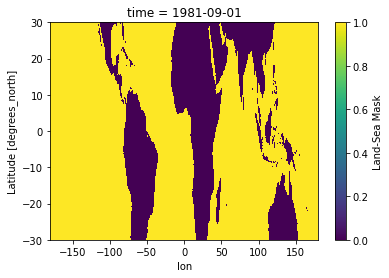

In [31]:
ds_lsm=xr.open_dataset('/home/fiaz/MDTF/files/lsmask.oisst.v2.nc')
lsm=ds_lsm.lsmask.sel(lat=slice(-30,30))
lsm=lsm.squeeze('time')
lsm.coords['lon'] = (lsm.coords['lon'] + 180) % 360 - 180
lsm = lsm.sortby(lsm.lon)

### We see that land=0; ocean=1
lsm.plot()
# lat=lsm.lat.values
# lon=lsm.lon.values

# lsm=lsm.values


In [32]:
# del REGION
REGION=lsm.copy(deep=True)
lc = REGION.coords["lon"]
la = REGION.coords["lat"]

##WP
REGION.loc[dict(lon=lc[(lc > 115) & (lc < 180)])] = 4

##EP
REGION.loc[dict(lon=lc[(lc > -180) & (lc < -100)])] = 3
REGION.loc[dict(lon=lc[(lc > -100) & (lc < -70)], lat=la[(la > -30) & (la < 10)])] = 3
REGION.loc[dict(lon=lc[(lc > -100) & (lc < -85)], lat=la[(la > 10) & (la < 17)])] = 3
REGION.loc[dict(lon=lc[(lc > -100) & (lc < -95)], lat=la[(la > 15) & (la < 18)])] = 3



## ATL.
REGION.loc[dict(lon=lc[(lc > -70) & (lc < 30)])] = 2
REGION.loc[dict(lon=lc[(lc > -85) & (lc < -70)],lat=la[(la > 10) & (la < 30)])] = 2
REGION.loc[dict(lon=lc[(lc > -98) & (lc < -80)],lat=la[(la > 20) & (la < 30)])] = 2
REGION.loc[dict(lon=lc[(lc > -90) & (lc < -80)],lat=la[(la > 16) & (la < 21)])] = 2
REGION.loc[dict(lon=lc[(lc > -100) & (lc < -85)],lat=la[(la > 18) & (la < 22)])] = 2



##IO
REGION.loc[dict(lon=lc[(lc > 30) & (lc < 100)])] = 1


# REGION.loc[dict(lon=lc[(lc > -98) & (lc < -80)],lat=la[(la > 20) & (la < 30)])] = 2

REGION=REGION.where(lsm>=1)
# REGION=REGION.where(REGION>1)
REGION=REGION.fillna(0)

In [33]:
### REGIONS: 5- IO, 4-WP, 3-EP, 2-AT, 1-Unclassified

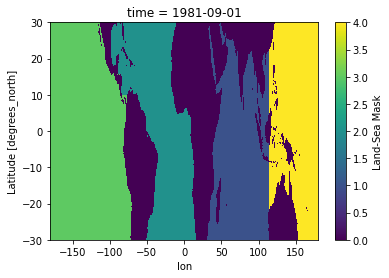

In [34]:
REGION.plot()

In [35]:
def generate_region_mask(region_ds, ds):
        '''
        Function adopted from Y-H Kuo's version
        '''

        print("...generating region mask..."),

        # Load & Pre-process Region Mask
        region=region_ds.values
        lat_m=region_ds.lat.values
        lon_m=region_ds.lon.values
        lon_m=np.append(lon_m,lon_m[0]+360)
        lon_m=np.insert(lon_m,0,lon_m[-2]-360)
        temp=region[:,0][:,None]
        region=np.concatenate((region,region[:,0][:,None]),axis=1)
        temp=region[:,-2][:,None]
        region=np.concatenate((region[:,-2][:,None],region),axis=1)
        
        LON,LAT=np.meshgrid(lon_m,lat_m,sparse=False,indexing="xy")
        LAT=np.reshape(LAT,(-1,1))
        LON=np.reshape(LON,(-1,1))
        REGION=np.reshape(region,(-1,1))
        LATLON=np.squeeze(np.array((LAT,LON)))
        LATLON=LATLON.transpose()

        regMaskInterpolator=NearestNDInterpolator(LATLON,REGION)

        # Interpolate Region Mask onto Model Grid using Nearest Grid Value
        lon=np.copy(ds.lon.values)
        lat=np.copy(ds.lat.values)
        
        LAT,LON=np.meshgrid(lat,lon,sparse=False,indexing="xy")
        LAT=np.reshape(LAT,(-1,1))
        LON=np.reshape(LON,(-1,1))
        LATLON=np.squeeze(np.array((LAT,LON)))
        LATLON=LATLON.transpose()
        REGION=np.zeros(LAT.size)
        for latlon_idx in np.arange(REGION.shape[0]):
            REGION[latlon_idx]=regMaskInterpolator(LATLON[latlon_idx,:])
        REGION=np.reshape(REGION.astype(int),(-1,lat.size))

        print("...Generated!")

        return REGION

In [36]:
REGION_MODEL=generate_region_mask(REGION, ta_ds['HIST'])

lsm_model = xr.DataArray(
     data=REGION_MODEL.T,
     dims=["lat", "lon"],
     coords=dict(
         lon=(ta_ds['HIST'].lon),
         lat=(ta_ds['HIST'].lat),
     ),
     attrs=dict(
         description="Region Mask 0-Land, 1-IO, 2-ATL, 3-EPAC, 4-WPAC "
     ),)

...generating region mask...


AttributeError: 'NoneType' object has no attribute 'lon'

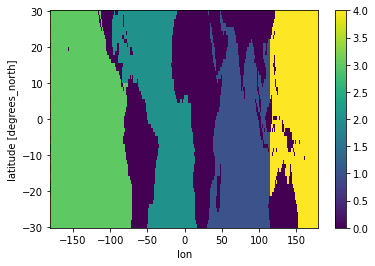

In [234]:
lsm_model.plot()

### Specify files to compare ###
As an example, we will just compare the historical model outputs to SSP585 <br>

### Set thresholds to compare ###
#### default is set to 1 mm/hr; change to other thresholds to play around

In [26]:
### get list of precip. thresholds ###
pthresh_list_full=list(cluster_dict[model_names_HIST[0]]['hist_pcp_sizes'].keys())
pthresh_ix=pthresh_list_full.index(1.0)  ### change to 1.0, 0.75, 0.50, 0.25
pthresh_list=pthresh_list_full[pthresh_ix:pthresh_ix+1]
pthresh_list

[1.0]

In [27]:
nthresh=25

def extract_grid_info(dict_input):
    
    sizes=dict_input['sizes']
    sz=(sizes[:-1]+sizes[1:])*0.5
    sz_diff=np.diff(sizes)   
    
    precip_cluster_power_scale=dict_input['precip_cluster_power_scale']
    pcp_clus_pow_bins=sizes*precip_cluster_power_scale*0.5
    pcp_clust_sz=(pcp_clus_pow_bins[:-1]+pcp_clus_pow_bins[1:])*0.5
    
    pcp_clust_sz_diff=np.diff(pcp_clus_pow_bins)

    power_scale=dict_input['precip_cluster_power_scale']
    pixels_to_area=dict_input['pixels_to_area']

    return sz,pcp_clust_sz,sz_diff,pcp_clust_sz_diff,power_scale,pixels_to_area



def extract_com_info(cluster_dict,pthresh):
    cluster_centroid_coords=cluster_dict['cluster_centroid_coords'][pthresh]
    return  cluster_centroid_coords     

def shift_pdf(pdf, ref_pdf, xval, ref_xval, offsets, second_shift ):
    ind_max=np.nanargmax(pdf)
    xmax=xval[ind_max]
    ind_ref_max=np.argmin(abs(ref_xval-xmax))
    first_shift=ref_pdf[ind_ref_max]/pdf[ind_max]    
    shifted_pdf=pdf*first_shift*second_shift
    offsets=offsets*first_shift*second_shift
    return shifted_pdf,offsets
    

def wilson_score(ns,n,alpha):
    
        '''
        Here ns is the number of sucesses in a Bernoulli Trial, i.e., the number of samples in a given bin
        n is the number of Bernoulli trials, i.e., the number of samples overall
        alpha is the percent of confidence interval (e.g. 5%)
        '''        
        z=norm.ppf(alpha/2) ## get the probit of the confidence interval
#         err_upper=(ns/n)+z*np.sqrt(ns*(n-ns))/(n*np.sqrt(n))
#         err_lower=(ns/n-z)*np.sqrt(ns*(n-ns))/(n*np.sqrt(n))
    
        err_upper=(ns+0.5*z**2)/(n+z**2)+z/(n+z**2)*np.sqrt(ns*(n-ns)/n+z**2/4)
        err_lower=(ns+0.5*z**2)/(n+z**2)-z/(n+z**2)*np.sqrt(ns*(n-ns)/n+z**2/4)

        return err_lower, err_upper

def get_errors(hist, pdf, diff, alpha):

    error_lower,error_upper=wilson_score(hist,hist.sum(),alpha)
    error=np.array((error_lower/diff,error_upper/diff))
    offsets=abs(pdf-error)## create error bars
    
    return offsets
    

In [28]:
def compute_regional_pdfs(cluster_dict,pthresh,centroid_info, region_mask, lsm):
    
    hist_pcp_sizes={}
    hist_pcp_clust_pow={}
    
    hist_pcp_clust_size_pdf={}
    hist_pcp_clust_pow_pdf={}
    
    pcp_sizes={}
    pcp_power={}
    
    sz={}
    pcp_clust_sz={}
    sz_diff={}
    pcp_clust_sz_diff={}
    power_scale={}
    pixels_to_area={}
    am={}
    cm={}
    
    lat=lsm.lat.values
    lon=lsm.lon.values
    lsm_vals=lsm.values
        
    lat_indx=np.int_((centroid_info[0,:]-(lat[0]))/np.diff(lat)[0])
    lon_indx=np.int_((centroid_info[1,:]-(lon[0]))/np.diff(lon)[0])
    lsm_region=lsm_vals[lat_indx,lon_indx]
    lsm_region=lsm_vals[lat_indx,lon_indx]
    ind_region=np.where(lsm_region==region_mask)[0]
    
    ### Read power and size
    
    pcp_sizes=cluster_dict['pcp_sizes'][pthresh][ind_region]
    pcp_power=cluster_dict['pcp_power'][pthresh][ind_region]
    
    ### Get grid information
        
    sz,pcp_clust_sz,sz_diff,pcp_clust_sz_diff,power_scale, pixels_to_area=extract_grid_info(cluster_dict)

    hist_pcp_sizes=np.histogram(pcp_sizes,
                                bins=cluster_dict['sizes'])[0]
    
    hist_pcp_clust_pow=np.histogram(pcp_power,
                                bins=cluster_dict['sizes']*cluster_dict['precip_cluster_power_scale'])[0]
    
    
    hist_pcp_clust_size_pdf=hist_pcp_sizes/(sz_diff*hist_pcp_sizes.sum())
    hist_pcp_clust_size_pdf[hist_pcp_sizes<nthresh]=np.nan

    hist_pcp_clust_pow_pdf=hist_pcp_clust_pow/(pcp_clust_sz_diff*hist_pcp_clust_pow.sum())
    hist_pcp_clust_pow_pdf[hist_pcp_clust_pow==0]=np.nan

    am=np.mean(pcp_sizes**2)*pixels_to_area/np.mean(pcp_sizes)
    cm=np.mean(pcp_power**2)/np.mean(pcp_power)
    sz_scaled=sz*pixels_to_area
        
    return hist_pcp_sizes, hist_pcp_clust_pow, hist_pcp_clust_size_pdf, hist_pcp_clust_pow_pdf, am, cm, sz_scaled, pcp_clust_sz, sz_diff,pcp_clust_sz_diff

In [29]:
### REGIONS: 0-Land; 1- IO; 2-AT; 3-EP; 4-WP; 
region_name={}
region_name[0]='Land'
region_name[1]='IO'
region_name[2]='Atl.'
region_name[3]='EPac.'
region_name[4]='WPac.'

In [30]:
ref_hist_sizes={}
ref_hist_pow={}
ref_size_pdf={}
ref_power_pdf={}
ref_am={}
ref_cm={}
ref_sz_scaled={}
ref_pow_scaled={}
centroid_info={}

### REGIONS: 1- IO, 2-ATL 3-EP, 4-WP, 0-Land
for region_mask in range(0,5):
    for key in obs_name:
        centroid_info[key]=extract_com_info(cluster_dict[key],pthresh_list[0])
        ret=compute_regional_pdfs(cluster_dict[key],pthresh_list[0],centroid_info[key],region_mask,REGION)
        ref_hist_sizes[region_mask], ref_hist_pow[region_mask], ref_size_pdf[region_mask], ref_power_pdf[region_mask], ref_am[region_mask], ref_cm[region_mask], ref_sz_scaled[region_mask], ref_pow_scaled[region_mask], sz_diff, pcp_clust_sz_diff=ret 


NameError: name 'REGION' is not defined

### Plot PDFS ###

In [241]:
### set colors (same size as data keys)
colors=['black','red','green','orange']
data_keys=obs_name+model_names_HIST

#### We will artificially shift the each pdf by a factor  of (default=$10^{-2}$) for visual clarity

In [242]:
data_keys

['TRMM3B42_200201_201412', 'BCC-CSM2-MR_200201_201412']

In [243]:
shift_factor=-3 ### shift is 1e-2
shifts={}
color_dicts={}
for i,j in enumerate(data_keys):
    color_dicts[j]=colors[i]
    shifts[j]=10**(shift_factor*i)

In [244]:
def prep_pdf(hist, pdf, pdf_diff, ref_pdf, xvar, ref_xvar, shift):
    offsets=get_errors(hist, pdf, pdf_diff, alpha)
    pdf,offsets=shift_pdf(pdf, ref_pdf, xvar, ref_xvar, offsets, shift)
    pdf[hist<nthresh]=np.nan
    return pdf, offsets

def fit_power_law_slope(xvar,ypdf,istrt,iend,thresh,plot_type='loglog'):
    ### Use the slope and intercept from the linear regression to create the straight line ###

    if plot_type=='loglog':
        arrx,arry=np.log10(xvar),np.log10(ypdf)
        arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<iend)],arry[np.logical_and(arrx>istrt,arrx<iend)]
        ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])
        pdf_fit=((xvar)**(ret[0]))*(10**(ret[1]))
        
        ## Remove portions of the straight line that extend too far beyond the cutoff
        pdf_fit[xvar>thresh]=np.nan 
        return pdf_fit
        
    elif plot_type=='logylinearx':
        arrx,arry=xvar,np.log10(ypdf)
        arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<iend)],arry[np.logical_and(arrx>istrt,arrx<iend)]
        ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])
        pdf_fit=10**(xvar*ret[0]+ret[1])
        pdf_fit[xvar>thresh]=np.nan 
        sL=-1./(ret[0]*np.log(10))
        return pdf_fit,sL


In [245]:
### Some user defined parameters ###
nthresh=10 #Discard bins with fewer than nthresh samples
istrt_sz,iend_sz=2.0,5.0 ## the power law range for size (10^3 to 10^5)
istrt_pow,iend_pow=3.0,5.0 ### set a ballpark range for the power law, so the straight line fit is over that range

title_fontsize=14
xlabel_fontsize=16.5
ylabel_fontsize=16.5

## x and yaxis limits for cluster size
xlim_sz=[1e2,1e7] 
ylim_sz=[1e-25,1e0] ##

## x and yaxis limits for cluster power
xlim_pow=[5e2,1.0e8] ##
ylim_pow=[1e-28,1e-1] ##

## threshold legend font size
leg_fontsize=12.5

## moment ratio * power law slope font size
leg1_fontsize=13.5

## ticklabel font size
ticks_fontsize=14

### legend location ###
leg_loc=(.5, .65)

### errorbar options ###
errorbar=True
alpha=0.05

In [246]:
def compute_plot_region_pdf(ax1,ax2,model_name,dict_input,pthresh,region_mask,
                            REGION, shift,marker_color, plot_fit, ln1, cutoff_list, annotate_region=False,
                            plot_type='loglog', get_legend=False):
    
        centroid_info=extract_com_info(dict_input,pthresh)
        ret=compute_regional_pdfs(dict_input,pthresh,centroid_info,region_mask,REGION) 
        histogram_size, histogram_pow, size_pdf, power_pdf, am, cm, sz_scaled, pcp_clust_sz, sz_diff, pcp_clust_sz_diff=ret


        size_pdf,offsets_sz=prep_pdf(histogram_size,
             size_pdf, sz_diff, ref_size_pdf[region_mask], sz_scaled, ref_sz_scaled[region_mask], shift)

        power_pdf,offsets_pow=prep_pdf(histogram_pow,
                 power_pdf, pcp_clust_sz_diff, ref_power_pdf[region_mask], pcp_clust_sz, ref_pow_scaled[region_mask], shift)
        
        ### there are the start and end of the power law range: adjust according to eye ###

        if plot_type=='loglog':
        
            ax1.loglog(sz_scaled,size_pdf,marker='*',
                                c=marker_color,markersize=5)
            if get_legend:
            
                ln1[region_mask]=ax1.errorbar(sz_scaled, size_pdf, yerr=offsets_sz,fmt='*',
                                    c=marker_color,markersize=5,capsize=2.25)

            else:
                ax1.errorbar(sz_scaled, size_pdf, yerr=offsets_sz,fmt='*',
                    c=marker_color,markersize=5,capsize=2.25)
                
            if annotate_region:
                ax1.text(xlim_sz[0]*1.25,np.nanmax(ref_size_pdf[region_mask][20]*shift),
                         '%s'%(region_name[region_mask]),transform=ax1.transData,fontsize=13)

            ax2.loglog(pcp_clust_sz, power_pdf, marker='*',c=marker_color,markersize=5)
            ax2.errorbar(pcp_clust_sz, power_pdf, yerr=offsets_pow, fmt='*',
                                c=marker_color,markersize=5,capsize=2.25)

            ### The straight line fit to the power law range ###
            ### select portions of the curve bounded by the power law range ###
            pdf_pcp_sizes=fit_power_law_slope(sz_scaled,size_pdf,istrt_sz,iend_sz,5e6)
            pdf_pcp_pow=fit_power_law_slope(pcp_clust_sz,power_pdf,istrt_pow,iend_pow,1e7)
        
            if plot_fit:
                ax1.loglog(sz_scaled,pdf_pcp_sizes*1e0,linestyle='--',c=color_dicts[key])
                ax2.loglog(pcp_clust_sz,pdf_pcp_pow*1e0,linestyle='--',c=color_dicts[key])
                
        elif plot_type=='logylinearx':
            
            aL,cL=cutoff_list[0],cutoff_list[1]

            ax1.semilogy(sz_scaled,size_pdf,marker='*',
                                c=marker_color,markersize=5)
            if get_legend:
                ln1[region_mask]=ax1.errorbar(sz_scaled, size_pdf, yerr=offsets_sz,fmt='*',
                                    c=marker_color,markersize=5,capsize=2.25)

            else:
                ax1.errorbar(sz_scaled, size_pdf, yerr=offsets_sz,fmt='*',
                                    c=marker_color,markersize=5,capsize=2.25)
                
            if annotate_region:

                ax1.text(xlim_sz[-1]*0.75,np.nanmax(ref_size_pdf[4][30]*shift*10**-2),
                         '%s'%(region_name[region_mask]),transform=ax1.transData,fontsize=13)


            ax2.semilogy(pcp_clust_sz, power_pdf, marker='*',c=marker_color,markersize=5)
            ax2.errorbar(pcp_clust_sz, power_pdf, yerr=offsets_pow, fmt='*',
                                c=marker_color,markersize=5,capsize=2.25)
            
            pdf_pcp_sizes,aL[region_mask]=fit_power_law_slope(sz_scaled,size_pdf,istrt_sz,iend_sz,iend_sz,'logylinearx')
            pdf_pcp_pow,cL[region_mask]=fit_power_law_slope(pcp_clust_sz,power_pdf,istrt_pow[region_mask],iend_pow[region_mask],
                                                            iend_pow[region_mask],'logylinearx')
            
            if plot_fit:
            
                ax1.semilogy(sz_scaled,pdf_pcp_sizes,linestyle='--',c=marker_color)
                ax2.semilogy(pcp_clust_sz,pdf_pcp_pow,linestyle='--',c=marker_color)
                
        
        return pdf_pcp_sizes,pdf_pcp_pow


In [247]:
### set colors for each region
region_colors={0:'magenta',1:'green',2:'orange',3:'cyan',4:'black'}

TRMM3B42_200201_201412 []
BCC-CSM2-MR_200201_201412 ['SSP585_BCC-CSM2-MR_209101_210012']
plot saved as ./regional_pdfs_BCC-CSM2-MR_200201_201412_SSP585_BCC-CSM2-MR_209101_210012_1.0.pdf


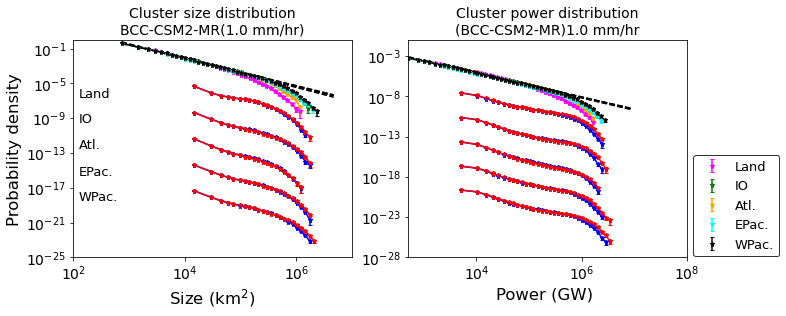

In [248]:
cutoff_list=[]
### set the plot specs:
### size
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

plot_type='loglog'
### create empty dictionaries to hold the legends 
ln1={}
ln2={}

### positions for some of the text on the plot
posy=[ 0.85, 0.9, 0.95, 0.725, .8, .875 ]
posx=[.65, 0.65, 0.65, .4, .4 ]
pos_slope=[0.65, 0.9]
pdf_pcp_sizes={}
pdf_pcp_pow={}

for j,key in enumerate(data_keys):
    
    ### check the model name and extract corresponding SSP file ###
    model_name=(key.split('_')[0])
    model_fil_ssp=[i for i in model_names_SSP if model_name in i]
    print(key,model_fil_ssp)

    ### if more than one SSP name is extracted, differentiate based on string split ###
    if len(model_fil_ssp)>1:
        for k in model_fil_ssp:
            if(k.split('_')[1])==model_name:
                model_fil_ssp=[k]
                
    plot_fit=True if key==obs_name[0] else False
    
    for region_mask in region_name.keys():
        
        
        if model_name=='TRMM3B42':
            marker_color=region_colors[region_mask]
            shift=1
            annotate_region=False
            get_legend=True
        else:
            marker_color='blue'
            shift=shifts[key]*10**(-3*region_mask) 
            annotate_region=True
            get_legend=False
        
        pdf_pcp_sizes[key],pdf_pcp_pow[key]=compute_plot_region_pdf(ax1,ax2,model_name,cluster_dict[key],pthresh_list[0],
                                                                    region_mask,REGION,shift,marker_color,plot_fit,ln1,
                                                                    cutoff_list, annotate_region,
                                                                    plot_type,get_legend)

        ### if a matching SSP file is found, plot it on top

        if model_fil_ssp:
            marker_color='red'
            annotate_region=False
            compute_plot_region_pdf(ax1,ax2,model_name,cluster_dict[model_fil_ssp[0]],
                                    pthresh_list[0],region_mask, REGION, shift,
                                    marker_color, plot_fit,ln1,cutoff_list, 
                                    annotate_region, plot_type,get_legend)

        
    
    if (j == 1):

        ### Set plot title and axis labels
        ax1.set_title("Cluster size distribution\n%s(%.1f mm/hr)"%(model_name,pthresh_list[0]),fontsize=title_fontsize)
        ax1.set_xlabel("Size ($\mathrm{km^2}$) ",fontsize=xlabel_fontsize)
        ax1.set_ylabel("Probability density",fontsize=ylabel_fontsize)
        ax1.set_xlim(xlim_sz)
        ax1.set_ylim(ylim_sz)
#         ax1.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
        ax1.tick_params(which='both', labelsize=ticks_fontsize)
        
        ax2.set_title("Cluster power distribution\n(%s)%.1f mm/hr"%(model_name,pthresh_list[0]),fontsize=title_fontsize)
        ax2.set_xlabel("Power (GW) ",fontsize=xlabel_fontsize)
        ax2.set_xlim(xlim_pow)
        ax2.set_ylim(ylim_pow)
#         ax2.yaxis.set_major_locator(plt.FixedLocator([1e-2, 1e-4, 1e-6, 1e-8, 1e-10,1e-12]))
        ax2.tick_params(which='both', labelsize=ticks_fontsize)

leg_artists=[]
leg_labels=[]
for keys in ln1:
    leg_artists.append(ln1[keys])
    leg_labels.append(region_name[keys])
    
leg=ax2.legend(leg_artists,leg_labels,bbox_to_anchor=[1.0, 0.5],fontsize=13)
frame=leg.get_frame()
frame.set_edgecolor('black')
### Be careful to not overwrite figures, change file name as the number of models/time periods change
    
SAVE_FIG=True
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"regional_pdfs_%s_%s_%.1f"%(model_names_HIST[0],model_names_SSP[0],pthresh_list[0])+".pdf"
    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')
    print('plot saved as {}'.format(save_fig_name))

### Replot as a log linear ###

In [249]:
## x and yaxis limits for cluster size
xlim_sz=[1e2,0.5e7] 
ylim_sz=[1e-25,1e0] ##

## x and yaxis limits for cluster power
xlim_pow=[5e2,0.5e7] ##
ylim_pow=[1e-28,1e-1] ##

istrt_sz,iend_sz=0.5e6,5.0e6 
# istrt_pow,iend_pow=1.8e6,8.0e6 

### setting different ranges based on basin ###
istrt_pow={}
iend_pow={}


istrt_pow[0],iend_pow[0]=0.5e6,5.2e6 
istrt_pow[1],iend_pow[1]=0.5e6,5.2e6  
istrt_pow[2],iend_pow[2]=0.5e6,5.2e6  
istrt_pow[3],iend_pow[3]=0.5e6,5.2e6  
istrt_pow[4],iend_pow[4]=0.5e6,5.2e6 


In [250]:
model_names_SSP[0]

'SSP585_BCC-CSM2-MR_209101_210012'

In [251]:
am={}
cm={}
aL={}
cL={}

for key in data_keys+model_names_SSP:
    am[key]={}
    aL[key]={}
    cm[key]={}
    cL[key]={} 


TRMM3B42_200201_201412 []
BCC-CSM2-MR_200201_201412 ['SSP585_BCC-CSM2-MR_209101_210012']


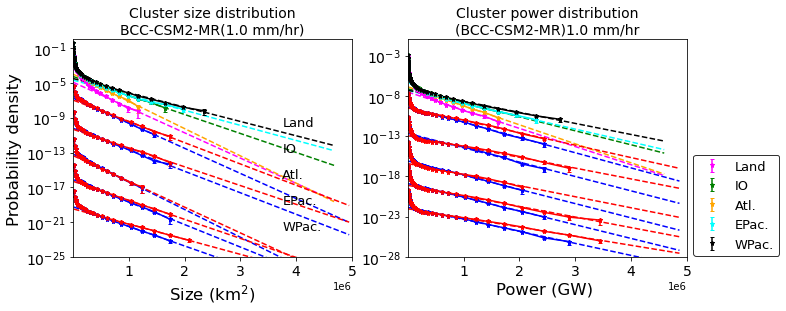

In [252]:
### set the plot specs:
### size
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

plot_type='logylinearx'
### create empty dictionaries to hold the legends 
ln1={}
ln2={}

### positions for some of the text on the plot
posy=[ 0.85, 0.9, 0.95, 0.725, .8, .875 ]
posx=[.65, 0.65, 0.65, .4, .4 ]
pos_slope=[0.65, 0.9]
pdf_pcp_sizes={}
pdf_pcp_pow={}

for j,key in enumerate(data_keys):
    
    ### check the model name and extract corresponding SSP file ###
    model_name=(key.split('_')[0])
    model_fil_ssp=[i for i in model_names_SSP if model_name in i]
    print(key,model_fil_ssp)

    ### if more than one SSP name is extracted, differentiate based on string split ###
    if len(model_fil_ssp)>1:
        for k in model_fil_ssp:
            if(k.split('_')[1])==model_name:
                model_fil_ssp=[k]
                
#     plot_fit=True if key==obs_name[0] else False
    
    for region_mask in region_name.keys():
#         print(region_mask)
        
        if model_name=='TRMM3B42':
            marker_color=region_colors[region_mask]
            shift=1
            annotate_region=False
            get_legend=True
            plot_fit=True
        else:
            marker_color='blue'
            shift=shifts[key]*10**(-3*region_mask) 
            annotate_region=True
            get_legend=False
            plot_fit=True
            
        cutoff_list=[aL[key],cL[key]]
        pdf_pcp_sizes[key],pdf_pcp_pow[key]=compute_plot_region_pdf(ax1,ax2,model_name,cluster_dict[key],pthresh_list[0],
                                                                    region_mask,REGION,shift,marker_color,plot_fit,ln1,
                                                                    cutoff_list, annotate_region,
                                                                    plot_type,get_legend)

        
        ### if a matching SSP file is found, plot it on top

        if model_fil_ssp:
            marker_color='red'
            annotate_region=False
            cutoff_list=[aL[model_fil_ssp[0]],cL[model_fil_ssp[0]]]


            compute_plot_region_pdf(ax1,ax2,model_name,cluster_dict[model_fil_ssp[0]],
                                    pthresh_list[0], region_mask, REGION, shift,
                                    marker_color, plot_fit, ln1, cutoff_list, 
                                    annotate_region, plot_type, get_legend)

        
    if (j == 1):

        ### Set plot title and axis labels
        ax1.set_title("Cluster size distribution\n%s(%.1f mm/hr)"%(model_name,pthresh_list[0]),fontsize=title_fontsize)
        ax1.set_xlabel("Size ($\mathrm{km^2}$) ",fontsize=xlabel_fontsize)
        ax1.set_ylabel("Probability density",fontsize=ylabel_fontsize)
        ax1.set_xlim(xlim_sz)
        ax1.set_ylim(ylim_sz)
#         ax1.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
        ax1.tick_params(which='both', labelsize=ticks_fontsize)
        
        ax2.set_title("Cluster power distribution\n(%s)%.1f mm/hr"%(model_name,pthresh_list[0]),fontsize=title_fontsize)
        ax2.set_xlabel("Power (GW) ",fontsize=xlabel_fontsize)
        ax2.set_xlim(xlim_pow)
        ax2.set_ylim(ylim_pow)
#         ax2.yaxis.set_major_locator(plt.FixedLocator([1e-2, 1e-4, 1e-6, 1e-8, 1e-10,1e-12]))
        ax2.tick_params(which='both', labelsize=ticks_fontsize)

leg_artists=[]
leg_labels=[]
for keys in ln1:
    leg_artists.append(ln1[keys])
    leg_labels.append(region_name[keys])
    
leg=ax2.legend(leg_artists,leg_labels,bbox_to_anchor=[1.0, 0.5],fontsize=13)
frame=leg.get_frame()
frame.set_edgecolor('black')
### Be careful to not overwrite figures, change file name as the number of models/time periods change
    
SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"loglinear_regional_pdfs_%s_%s_%.1f"%(model_names_HIST[0],model_names_SSP[0],pthresh_list[0])+".pdf"
    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')
    print('plot saved as {}'.format(save_fig_name))

### for a given model, what are the changes across basin ###

In [253]:
cL_obs=list(cL[obs_name[0]].values())
cL_HIST=list(cL[model_names_HIST[0]].values())
cL_SSP=list(cL[model_names_SSP[0]].values())

aL_obs=list(aL[obs_name[0]].values())
aL_HIST=list(aL[model_names_HIST[0]].values())
aL_SSP=list(aL[model_names_SSP[0]].values())

delta_comp=lambda x,y:(y-x)*100./x
delta_cL=list(map(delta_comp,cL_HIST,cL_SSP))
delta_aL=list(map(delta_comp,aL_HIST,aL_SSP))



In [254]:
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

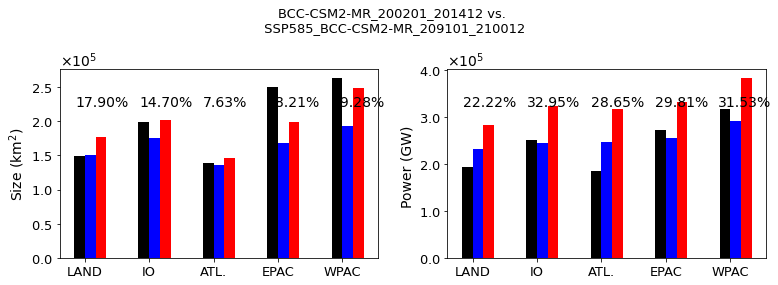

In [255]:
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax1.bar(np.arange(0,15,3),aL_obs,color='black',width=0.5)
ax1.bar(np.arange(0,15,3)+0.5,aL_HIST,color='blue',width=0.5)
ax1.bar(np.arange(0,15,3)+1.0,aL_SSP,color='red',width=0.5)


ax1.set_xticks(np.arange(0.25,15.25,3))
ax1.set_xticklabels(['LAND','IO','ATL.','EPAC','WPAC'],fontsize=13)
ax1.tick_params(which='both',labelsize=13)
ax1.yaxis.set_major_formatter(OOMFormatter(5, "%1.1f"))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
ax1.yaxis.get_offset_text().set_fontsize(14)

for n,i in enumerate(delta_aL):
    ax1.text(0.05+n/len(delta_aL),0.8,"%.2f"%(i)+'%',
             transform=ax1.transAxes,fontsize=14)

ax1.set_ylabel("Size ($\mathrm{km^2}$) ",fontsize=14)


ax2 = plt.subplot(gs[0, 1])

ax2.bar(np.arange(0,15,3),cL_obs,color='black',width=0.5)
ax2.bar(np.arange(0,15,3)+0.5,cL_HIST,color='blue',width=0.5)
ax2.bar(np.arange(0,15,3)+1.0,cL_SSP,color='red',width=0.5)

ax2.set_xticks(np.arange(0.25,15.25,3))
ax2.set_xticklabels(['LAND','IO','ATL.','EPAC','WPAC'],fontsize=13)
ax2.tick_params(which='both',labelsize=13)
ax2.yaxis.set_major_formatter(OOMFormatter(5, "%1.1f"))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
ax2.yaxis.get_offset_text().set_fontsize(14)

for n,i in enumerate(delta_cL):
    ax2.text(0.05+n/len(delta_cL),0.8,"%.2f"%(i)+'%',
             transform=ax2.transAxes,fontsize=14)

ax2.set_ylabel("Power (GW) ",fontsize=14)


fig.suptitle('%s vs.\n %s'%(model_names_HIST[0],model_names_SSP[0]),fontsize=13)
plt.tight_layout()


### Scaling these changes by surface temperature ###

In [256]:
tas_values_hist=ta_ds['HIST'].load()
tas_values_ssp=ta_ds['SSP'].load()

In [257]:
region_tas_HIST={}
region_tas_SSP={}


for region_mask in region_name.keys():
    
    tas1=tas_values_hist.copy(deep=True)
    region_tas_HIST[region_mask]=tas1.where(lsm_model==region_mask).mean().values

    tas1=tas_values_ssp.copy(deep=True)
    region_tas_SSP[region_mask]=tas1.where(lsm_model==region_mask).mean().values

    

In [258]:
delta_temp={}
for region_mask in region_name.keys():
    delta_temp[region_mask]=region_tas_SSP[region_mask]-region_tas_HIST[region_mask]

plot saved as ./regional_cutoff_scales_changes_BCC-CSM2-MR_200201_201412_SSP585_BCC-CSM2-MR_209101_210012_1.0.pdf


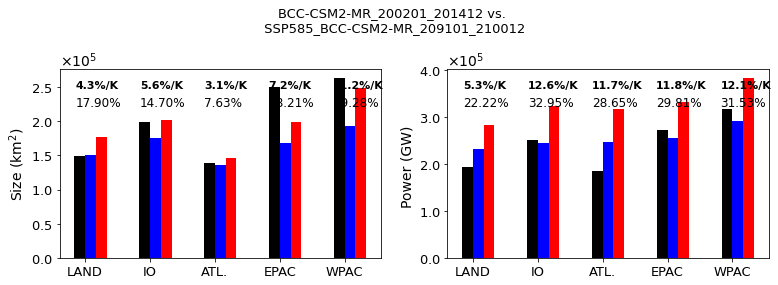

In [259]:
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax1.bar(np.arange(0,15,3),aL_obs,color='black',width=0.5)
ax1.bar(np.arange(0,15,3)+0.5,aL_HIST,color='blue',width=0.5)
ax1.bar(np.arange(0,15,3)+1.0,aL_SSP,color='red',width=0.5)


ax1.set_xticks(np.arange(0.25,15.25,3))
ax1.set_xticklabels(['LAND','IO','ATL.','EPAC','WPAC'],fontsize=13)
ax1.tick_params(which='both',labelsize=13)
ax1.yaxis.set_major_formatter(OOMFormatter(5, "%1.1f"))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
ax1.yaxis.get_offset_text().set_fontsize(14)

for n,i in enumerate(delta_aL):
    ax1.text(0.05+n/len(delta_aL),0.9,"%.1f"%(i/delta_temp[n])+'%/K',
             transform=ax1.transAxes,fontsize=11,weight='bold')

    ax1.text(0.05+n/len(delta_aL),0.8,"%.2f"%(i)+'%',
             transform=ax1.transAxes,fontsize=12)


    
ax1.set_ylabel("Size ($\mathrm{km^2}$) ",fontsize=14)


ax2 = plt.subplot(gs[0, 1])

ax2.bar(np.arange(0,15,3),cL_obs,color='black',width=0.5)
ax2.bar(np.arange(0,15,3)+0.5,cL_HIST,color='blue',width=0.5)
ax2.bar(np.arange(0,15,3)+1.0,cL_SSP,color='red',width=0.5)

ax2.set_xticks(np.arange(0.25,15.25,3))
ax2.set_xticklabels(['LAND','IO','ATL.','EPAC','WPAC'],fontsize=13)
ax2.tick_params(which='both',labelsize=13)
ax2.yaxis.set_major_formatter(OOMFormatter(5, "%1.1f"))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
ax2.yaxis.get_offset_text().set_fontsize(14)

for n,i in enumerate(delta_cL):
    ax2.text(0.05+n/len(delta_cL),0.9,"%.1f"%(i/delta_temp[n])+'%/K',
             transform=ax2.transAxes,fontsize=11,weight='bold')

    ax2.text(0.05+n/len(delta_cL),0.8,"%.2f"%(i)+'%',
             transform=ax2.transAxes,fontsize=12)

ax2.set_ylabel("Power (GW) ",fontsize=14)


fig.suptitle('%s vs.\n %s'%(model_names_HIST[0],model_names_SSP[0]),fontsize=13)


plt.tight_layout()


SAVE_FIG=True
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"regional_cutoff_scales_changes_%s_%s_%.1f"%(model_names_HIST[0],model_names_SSP[0],pthresh_list[0])+".pdf"
    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')
    print('plot saved as {}'.format(save_fig_name))


### Plot cluster density on map 



### Optional analysis to visualize the change in regional cluster distribution ###

In [10]:
(-np.diff(lat)[0])
com_coords_large_power[0,:].max()-lat[0]
np.int_(com_coords_large_power[0,:].max()-lat[0])
lat[63],com_coords_large_power[0,:].max()

NameError: name 'lat' is not defined

In [14]:
cluster_density={}
lat=np.arange(-35,36,1.0)
lon=np.arange(-180,180,1)


def compute_cluster_density(key,centroid_info,cluster_power,pow_thresh,
                            cluster_density):
    '''
    Compute number of clusters per 1 deg lat x lon 
    '''
    
    cluster_density[key]=np.zeros((lat.size,lon.size))

    com_coords_large_power=centroid_info[key][:,np.where(cluster_power[key]>pow_thresh)[0]]
    com_coords_large_power_lat_idx=np.int_((com_coords_large_power[0,:]-lat[0])/(np.diff(lat)[0]))
    com_coords_large_power_lon_idx=np.int_((com_coords_large_power[1,:]-lon[0])/(np.diff(lon)[0]))
    
    for j in np.arange(lon.size):
        for i in np.arange(lat.size):
            number=np.where(np.logical_and(com_coords_large_power_lat_idx==i,com_coords_large_power_lon_idx==j))
            cluster_density[key][i,j]=number[0].size
        
    cluster_density[key]=cluster_density[key]/(cluster_density[key].sum()*np.diff(lat)[0]*np.diff(lon)[0])

In [12]:
for key in centroid_info.keys():
    print(key)
    compute_cluster_density(key,centroid_region_info,cluster_power,cm[key],cluster_density)


NameError: name 'centroid_info' is not defined

In [13]:
cmap=plt.get_cmap('RdYlBu_r')
cmap_dif=plt.get_cmap('RdBu_r')

In [ ]:
key_obs='TRMM3B42_200201_201412'


(cluster_density[key]).max()
contour_levels=np.arange(0,0.525,0.025)
contour_levels_diff=np.arange(-0.3,0.325,0.025)

da = xr.DataArray(data=cluster_density[key_obs],
                  dims=["lat", "lon"],
                 coords={"lat":lat,"lon":lon})

In [ ]:
cm

### Fix error in plotting ###

In [ ]:
fig,axx = plt.subplots(3,1,figsize=(10, 8),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False)
# thresh=1.0
pow_thresh=1.0e6
# ## only plot the largest cluster centroids ###

ax=axx[0]
ax.coastlines()
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]], 
              crs=ccrs.PlateCarree())

key_obs='TRMM3B42_200201_201412'

ax.contourf(lon,lat,cluster_density[key_obs]*1e3,levels=contour_levels,extend='both',cmap=cmap,
            transform=ccrs.PlateCarree())
ax.set_aspect('auto')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.ylines = False

gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_title(obs_name[0],fontsize=14)


# ax.set_title('Precipitation cluster centroid distribution (%.2f mm/hr,$>%.0e$)\n%s-%s'%(thresh,pow_thresh,
#                                                                                   strt_date.strftime("%Y"),end_date.strftime("%Y")),
#              fontsize=15)

# plt.tight_layout()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
# if forcing=='SSP':
#     fname='precip_cluster_density_SSP585_%s_%s'%(model_list[model_index],select_date)+'.pdf'
# elif forcing=='HIST':
#     fname='precip_cluster_density_HIST_%s_%s'%(model_list[model_index],select_date)+'.pdf'    
# elif forcing=='obs':
#     fname='TRMM3B42_precip_cluster_density_HIST_%s_%s'%(time_slice.start.strftime("%Y%m"),time_slice.stop.strftime("%Y%m"))+'.pdf'    

ax=axx[1]
ax.coastlines()
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]], 
              crs=ccrs.PlateCarree())

key_hist='CNRM-CM6-1_200201_201412'

ax.contourf(lon,lat,cluster_density[key_hist]*1e3,levels=contour_levels,extend='both',cmap=cmap,
            transform=ccrs.PlateCarree())
ax.set_aspect('auto')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.ylines = False

gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_title(model_names_HIST[0],fontsize=14)



ax=axx[2]
ax.coastlines()
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]], 
              crs=ccrs.PlateCarree())

key_ssp='SSP585_CNRM-CM6-1_209101_210012'

ax.contourf(lon,lat,cluster_density[key_ssp]*1e3,levels=contour_levels,extend='both',cmap=cmap,
            transform=ccrs.PlateCarree())
ax.set_aspect('auto')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.ylines = False

gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_title(model_names_SSP[0],fontsize=14)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
# SAVE=False
# if SAVE:
#     plt.savefig('./plots/'+fname,format='pdf',dpi=150,bbox_inches='tight')

In [ ]:
fig,axx = plt.subplots(1,1,figsize=(10, 3),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False)
# thresh=1.0
pow_thresh=1.0e6
# ## only plot the largest cluster centroids ###

ax=axx
ax.coastlines()
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]], 
              crs=ccrs.PlateCarree())

ax.contourf(lon,lat,(cluster_density[key_ssp]-cluster_density[key_hist])*1e3,
            levels=contour_levels_diff,extend='both',cmap=cmap_dif,
            transform=ccrs.PlateCarree())
ax.set_aspect('auto')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.ylines = False

gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_title('Difference:%s\n%s'%(model_names_SSP[0],model_names_HIST[0]),fontsize=14)

In [ ]:
### Some user defined parameters ###
nthresh=25 #Discard bins with fewer than nthresh samples
istrt_sz,iend_sz=3.0,5.0 ## the power law range for size (10^3 to 10^5)
istrt_pow,iend_pow=4.0,5.5 ### set a ballpark range for the power law, so the straight line fit is over that range

title_fontsize=15
xlabel_fontsize=16.5
ylabel_fontsize=16.5

## x and yaxis limits for cluster size
xlim_sz=[1e2,0.5e7] 
ylim_sz=[1e-21,1e0] ##

## x and yaxis limits for cluster power
xlim_pow=[1e2,2.5e8] ##
ylim_pow=[1e-21,1e-1] ##

## threshold legend font size
leg_fontsize=12.5

## moment ratio * power law slope font size
leg1_fontsize=13.5

## ticklabel font size
ticks_fontsize=14

### vertical offset ###

